In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import torch._dynamo

torch._dynamo.reset()
torch._dynamo.config.verbose=True
torch._dynamo.config.suppress_errors = True

In [ ]:
# dataset

means = {
    'cifar10': [0.4914, 0.4822, 0.4465],
    'cifar100': [0.5071, 0.4867, 0.4408],
    'mnist':[0.5,0.5,0.5],
    'imagenet': [0.485, 0.456, 0.406]
}
stds = {
    'cifar10': [0.2023, 0.1994, 0.2010],
    'cifar100':[0.2675, 0.2565, 0.2761],
    'mnist':[0.5,0.5,0.5],
    'imagenet': [0.229, 0.224, 0.225]
}

class Twoview(torch.utils.data.Dataset):
    def __init__(self, train, cfg):
        super(Twoview, self).__init__()
        self.train = train
        self.augT = T.Compose([
            T.RandomResizedCrop((cfg["img_size"],cfg["img_size"]),
                                (1.0, 1.0), (1.0, 1.0)),
            T.ColorJitter(0.4,0.4,0.4,0.15),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(means[cfg["dataset"]], stds[cfg["dataset"]])
        ])
        self.stdT = T.Compose([
            T.ToTensor(),
            T.Normalize(means[cfg["dataset"]], stds[cfg["dataset"]])
        ])
        if cfg["dataset"] == "mnist":
            self.dataset = torchvision.datasets.MNIST("./home/aiuser/taeuk/Datasets", train=train, download=True)
            self.augT = T.Compose([
            T.RandomResizedCrop((cfg["img_size"],cfg["img_size"]),
                                scale=(0.5, 1.0)),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
            ])
            self.stdT = T.Compose([
                T.ToTensor(),
                T.Normalize([0.5], [0.5])
            ])
        elif cfg["dataset"]=="cifar10":
            self.dataset = torchvision.datasets.CIFAR10("./home/aiuser/taeuk/Datasets", train=train, download=True)
        elif cfg["dataset"]=="cifar100":
            self.dataset = torchvision.datasets.CIFAR100("./home/aiuser/taeuk/Datasets", train=train, download=True)

    def __getitem__(self, index):
        img, lab = self.dataset[index]
        if self.train:
            return self.augT(img), self.augT(img), lab
        else:
            return self.stdT(img), lab

    def __len__(self):
        return len(self.dataset)

def set_inference(cfg, model, device):
    channel = 1 if cfg["dataset"]=="mnist" else 3
    imgs = torch.zeros((1,channel,cfg["img_size"],cfg["img_size"]))
    labs = torch.zeros((1,))
    preds = torch.zeros((1,))
    logits = torch.zeros((1,cfg["dim_encoder"]))

    valid_loader = torch.utils.data.DataLoader(Twoview(False, cfg), 128, False)
    for img, lab in tqdm(valid_loader):
        with torch.no_grad():
            logit, _ = model(img.to(device))
            _, pred = (logit @ model.clusters.T).max(dim=1)

        imgs = torch.cat([imgs, img], dim=0)
        labs = torch.cat([labs, lab], dim=0)
        preds = torch.cat([preds, pred.cpu()], dim=0)
        logits = torch.cat([logits, logit.cpu()], dim=0)

    imgs = imgs[1:]
    labs = labs[1:]
    preds = preds[1:]
    logits = logits[1:]
    return imgs, labs, preds, logits

def set_inference_v2(cfg, model, device):
    channel = 1 if cfg["dataset"]=="mnist" else 3
    imgs = torch.zeros((1,channel,cfg["img_size"],cfg["img_size"]))
    labs = torch.zeros((1,))
    preds = torch.zeros((1,))
    logits = torch.zeros((1,cfg["dim_encoder"]))
    valid_loader = torch.utils.data.DataLoader(Twoview(False, cfg), 128, False)
    for img, lab in tqdm(valid_loader):
        with torch.no_grad():
            logit, _ = model(img.to(device))
            pred = []
            for i in range(cfg["num_levels"]):
                _, pred_ = (logit[:, i*cfg["dim_features"]:(i+1)*cfg["dim_features"]] @ \
                            model.clusters[i*cfg["sub_levels"]:(i+1)*cfg["sub_levels"], :].T).max(dim=1)
                pred.append(pred_.reshape(-1,1).cpu())
            pred = torch.cat(pred, dim=1)

        imgs = torch.cat([imgs, img], dim=0)
        labs = torch.cat([labs, lab], dim=0)
        preds = torch.cat([preds, pred.cpu()], dim=0)
        logits = torch.cat([logits, logit.cpu()], dim=0)

    imgs = imgs[1:]
    labs = labs[1:]
    preds = preds[1:]
    logits = logits[1:]
    return imgs, labs, preds, logits

def plotting(cfg, df, imgs):
    # cluster
    values = df.pred.value_counts()
    y = np.zeros((cfg["num_clusters"],))
    for j in values.keys():
        y[j] = values[j]
    plt.bar(np.arange(cfg["num_clusters"]), y)
    plt.xticks(np.arange(cfg["num_clusters"]),np.arange(cfg["num_clusters"]))
    plt.title("Clustering result")
    plt.grid()
    plt.show()

    # distribution label, image
    fig, axe = plt.subplots(cfg["num_clusters"]//5 ,5, figsize=(20, cfg["num_clusters"]//5 * 4))
    for i in range(cfg["num_clusters"]):
        values = df.loc[df.pred==i,"label"].value_counts()
        y = np.zeros((cfg["num_classes"],))
        for j in values.keys():
            y[j] = values[j]
        axe[i//5, i%5].bar(np.arange(cfg["num_classes"]), y)
        axe[i//5, i%5].grid()
        axe[i//5, i%5].set_xticks(np.arange(cfg["num_classes"]), np.arange(cfg["num_classes"]))
        axe[i//5, i%5].set_title("cluster "+str(i))
    fig.suptitle("Label")
    fig.show()

    fig, axe = plt.subplots(cfg["num_clusters"]//5, 5, figsize=(20, cfg["num_clusters"]//5 * 4))
    for i in range(cfg["num_clusters"]):
        idx = np.arange(imgs.size(0))[df.pred==i]
        img = imgs[idx]
        axe[i//5, i%5].axis("off")
        axe[i//5, i%5].set_title("cluster "+str(i))
        if list(img.numpy()):
            axe[i//5, i%5].imshow(np.transpose(torchvision.utils.make_grid(img[:400], nrow=20, normalize=True).numpy(), (1,2,0)))
    fig.suptitle("Image")
    fig.show()
    return

100%|██████████| 9912422/9912422 [00:00<00:00, 122410755.02it/s]


Extracting ./home/aiuser/taeuk/Datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./home/aiuser/taeuk/Datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16946795.44it/s]


Extracting ./home/aiuser/taeuk/Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./home/aiuser/taeuk/Datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31086849.45it/s]


Extracting ./home/aiuser/taeuk/Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./home/aiuser/taeuk/Datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15602398.66it/s]


Extracting ./home/aiuser/taeuk/Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./home/aiuser/taeuk/Datasets/MNIST/raw



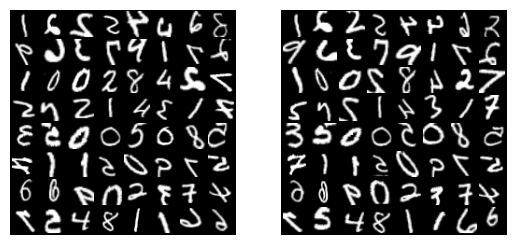

In [ ]:
# example
cfg = {
    "dataset":"mnist",
    "img_size":28,
    "batch_size":128,
    "num_clusters":10,
    "dim_encoder":128,
    "t":10,
    "num_epochs":100,
    "learning_rate":0.025
}
dataloader = torch.utils.data.DataLoader(Twoview(True, cfg), 128, True)
img1,img2, _ = next(iter(dataloader))

fig, axe = plt.subplots(1,2)
axe[0].imshow(np.transpose(torchvision.utils.make_grid(img1[:64], normalize=True),(1,2,0)))
axe[0].axis("off")
axe[1].imshow(np.transpose(torchvision.utils.make_grid(img2[:64], normalize=True),(1,2,0)))
axe[1].axis("off")
fig.show()

In [ ]:
# model

class Model(nn.Module):
    def __init__(self, cfg):
        super(Model, self).__init__()
        self.clusters = nn.Parameter(torch.randn(cfg["num_clusters"],
                                                 cfg["dim_features"]),
                                     requires_grad=True)
        c = 1 if cfg["dataset"]=="mnist" else 3
        self.main = nn.Sequential(
            nn.Conv2d(c, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, cfg["dim_encoder"], 3, 1, 1),
            nn.BatchNorm2d(cfg["dim_encoder"]),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1,1)))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(cfg["dim_encoder"], 128, 4, 1, 0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, c, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        logit = F.normalize(x.squeeze(), p=2, dim=1)
        img = self.decoder(x)
        return logit, img

In [ ]:
# objectives

def cluster_assignment(logit, clusters, cnt_threshold, device):
    clus = logit @ clusters.T
    max_v, _ = clus.max(dim=1)
    _, clus_idx = max_v.sort(descending=True, dim=0)
    _, clus_y_idx = clus[clus_idx].sort(descending=True, dim=1)
    clus_y = []
    clus_y_cnt = [0]*clusters.size(0)
    for idx in clus_y_idx:
        cand = [i for i in idx if clus_y_cnt[i] < cnt_threshold]
        if cand:
            clus_y.append(cand[0])
        else:
            clus_y.append(idx[0])
        clus_y_cnt[clus_y[-1]] += 1
    return clus, torch.tensor(clus_y, device=device), clus_idx

def objective(cfg, logit1, logit2, model_clusters, device):
    # hyperparameter
    t = cfg["temperature"]
    cnt_threshold = int(logit1.size(0)//cfg["sub_levels"] * 1.0)

    # similarity loss
    sim = logit1 @ logit2.T
    sim = sim - (sim.diag() * torch.ones_like(sim, device=device)).T
    loss_sim = F.cross_entropy(sim/t, torch.arange(logit1.size(0), device=device))

    # cluster orthogonalization
    loss_orth = 0.
    clus = model_clusters @ model_clusters.T
    clus = clus - (clus.diag() * torch.ones_like(clus, device=device)).T
    loss_orth += F.cross_entropy(clus/t, torch.arange(model_clusters.size(0), device=device))
    #loss_orth += F.mse_loss((clusters**2).sum(dim=1), torch.ones((clusters.size(0),), device=device))

    # cluster loss
    clus1, clus1_y, clus1_idx = cluster_assignment(logit1, model_clusters, cnt_threshold, device)
    clus2, clus2_y, clus2_idx = cluster_assignment(logit2, model_clusters, cnt_threshold, device)
    loss_clus = 0.
    loss_clus += F.cross_entropy(clus2[clus1_idx], clus1_y) + F.cross_entropy(clus1[clus2_idx], clus2_y)
    #loss_clus +=  F.cross_entropy(clus1[clus1_idx], clus1_y) + F.cross_entropy(clus2[clus2_idx], clus2_y)

    return cfg["alpha"] * (loss_sim + loss_clus/2) + (1-cfg["alpha"]) * loss_orth

In [ ]:
cfg = {
    "dataset":"mnist",
    "img_size":28,
    "num_classes":10,
    "num_levels":4,
    "sub_levels":4,
    "dim_features":32,
    "dim_encoder":4*32,
    "num_clusters":4*4,
    "alpha":0.4,
    "temperature":0.01,
    "batch_size":32,
    "num_epochs":10,
    "step_epoch":5,
    "learning_rate":0.025
}

dataloader = torch.utils.data.DataLoader(Twoview(True, cfg), cfg["batch_size"], True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg["learning_rate"])
model_compiled = torch.compile(model)

for epoch in tqdm(range(1, cfg["num_epochs"]+1)):
    losses_clu = 0.
    losses_rec = 0.
    for img1, img2, _ in dataloader:
        img1, img2 = img1.to(device), img2.to(device)
        optimizer.zero_grad()
        logit1, img1_rec = model_compiled(img1)
        logit2, img2_rec = model_compiled(img2)
        loss_clu = 0.
        for i in range(cfg["num_levels"]):
            loss_clu += objective(cfg, logit1[:, i*cfg["dim_features"]:(i+1)*cfg["dim_features"]],
                                       logit2[:, i*cfg["dim_features"]:(i+1)*cfg["dim_features"]],
                                       model.clusters[i*cfg["sub_levels"]:(i+1)*cfg["sub_levels"], :], device)
        loss_rec = (F.mse_loss(img1_rec, img1) + F.mse_loss(img2_rec, img2)) / 2
        loss = loss_rec + loss_clu
        loss.backward()
        optimizer.step()

        losses_clu += loss_clu.item()
        losses_rec += loss_rec.item()
    print("[Epoch %3d] [Loss %2.6f] [Rec %2.6f]"%(epoch, losses_clu/len(dataloader), losses_rec/len(dataloader)))

In [ ]:
imgs, labs, preds, logits = set_inference(cfg, model, device)



### 240105 자 실험

In [ ]:

imgs, labs, preds, logits = set_inference(cfg, model, device)
plotting(cfg, pd.DataFrame({"label":labs, "pred":preds}).astype(int), imgs)

In [ ]:
# k-mean evaluation

from sklearn.cluster import KMeans

X = logits.data.cpu().numpy()
kmean = KMeans(n_clusters=cfg["num_clusters"])
y_kmn = kmean.fit_predict(X)

df = pd.DataFrame({"label":labs, "pred":y_kmn}).astype(int)
plotting(cfg, df, imgs)

In [ ]:
df = pd.DataFrame({"label":labs, "pred":preds,"kmean":y_kmn}).astype(int)
res = df.groupby(["pred", "kmean"]).count().sort_values(by="label", ascending=False)[:25].reset_index()
res = res.sort_values(by="pred")
res

In [ ]:
center_kmean = kmean.cluster_centers_[res.kmean]
center_model = model.clusters.data.cpu().numpy()

m = center_kmean @ center_model.T
plt.imshow(m);